# Nobel Twin Cirrhosis Fecal Machine Learning Analysis
This workflow uses machine learning and features from Songbird to try and classify individuals as positive or negative for advanced fibrosis. I will create 3 different feature sets: songbird top 50, songbird bot 50 and songbird top 25+bot25. With each of these feature sets I will test the Random Forest classifer model and a logistic regression model and use the precision recall and ROC curves to test how well the models perform.

**Author: Tobin Groth (tgroth@ucsd.edu)**

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import qiime2
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pylab as pl
import qiime2
import os


os.chdir('/Users/tgroth/Google Drive/knight_twin_NAFLD/serum_analysis')

In [2]:
#loading in fecal metadata
meta = pd.read_csv('../metadata-matched.tsv',sep='\t',index_col=0)
meta.head(3)

,ATTRIBUTE_AgeInYears,ATTRIBUTE_BarcodeSequence,ATTRIBUTE_BiologicalSex,ATTRIBUTE_ChromatographyAndPhase,ATTRIBUTE_ComorbidityListDOIDIndex,ATTRIBUTE_Country,ATTRIBUTE_DOIDCommonName,ATTRIBUTE_DOIDOntologyIndex,ATTRIBUTE_DepthorAltitudeMeters,ATTRIBUTE_Description,...,ATTRIBUTE_waist_circumference_cm,ATTRIBUTE_water_lot,ATTRIBUTE_wbc,ATTRIBUTE_weight,ATTRIBUTE_weight_units,ATTRIBUTE_well_description,ATTRIBUTE_well_id,ATTRIBUTE_zygocity,ATTRIBUTE_zygoticity,filename
sampleid,,,,,,,,,,,,,,,,,,,,,
TW-CO-002,54,TCATGGCCTCCG,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,98,RNBF9925,8,80.6,kg,Loomba_Twin_Plate_2_TW.CO.002_E2,E2,2,2.0,TW-CO-002_RC4_01_35874.mzXML
TW-BT-001,49,CACACAAAGTCA,female,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,92,RNBF9925,8.5,80.8,kg,Loomba_Twin_Plate_2_TW.BT.001_E10,E10,1,1.0,TW-BT-001_RH12_01_35942.mzXML
TW-CA-002,61,TCCGGCGGGCAA,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,115,RNBF9925,6.2,99.7,kg,Loomba_Twin_Plate_2_TW.CA.002_B10,B10,1,1.0,TW-CA-002_RH6_01_35936.mzXML


In [3]:
meta.ATTRIBUTE_groups.value_counts()

G1P    48
G1R    37
G3R    30
G3P    22
G2P    16
G2R    14
Name: ATTRIBUTE_groups, dtype: int64

In [4]:
#loading in the hashed+scaled feature table
serum_table = qiime2.Artifact.load('feature_tables/serum-ft-hashed-matched-scaled.qza')
serum_tablepd = serum_table.view(pd.DataFrame)
serum_tablepd.head(3)

,0004069a1f2c3f2b14511a4f367e485d,0013ada35a72573fde974722d6f46269,0074f0d3d22016bcdf28ee53c8a5062b,012ade16945709e69650957b8fdeb021,015bcc773d2fe77d5ddf3533aff00a9f,0171c4a4201b9604da3efc9305fc5264,017460a73612042af020d72a944567b4,01809bb355414a0015fd764cba9c5014,01a15bb425333e9bb45a57970a4fd744,01f940cc9606a206fc0f5f4be686142a,...,fe8cbb81d1abec83ba4cc2e9f82dd552,febe3e034a4a2cb784dec089610dd34c,fecd9732b400a12637130cb39f076b17,ff0f37b5dc7b583b0990818a3ca3bd85,ff47eed94e12e32213900023846a2b25,fface4fa9e4315823b284edf46814f27,ffc858cfa01fda2a2b2c0a1344a0b87a,ffe5d35f6eb7b6d40c0b901f6576ca3c,ffeb115b9cba8e7fde3b05c27b47a913,fff8ef7ac71077d6ddc2c538ad270385
TW-CO-002,1.057551,0.713690,0.101371,0.133053,-0.286215,-0.318617,0.065534,-0.279881,0.117167,-0.301339,...,-0.719733,0.180132,-0.325997,-0.386096,-0.095690,-0.185462,-0.174831,-0.072250,0.065709,-0.985989
TW-BT-001,4.324877,3.217350,-0.021519,3.134937,6.154245,-0.316190,4.300775,0.274048,0.371661,-0.301339,...,-0.719733,1.366283,0.741181,-0.301068,-0.138150,-0.185047,-0.174998,0.048797,7.210811,-0.985989
TW-CA-002,-0.503911,0.362269,-0.075956,1.604561,0.699963,-0.318680,0.459769,0.823721,0.202315,-0.280759,...,-0.719733,1.618091,1.256980,-0.390866,-0.189908,-0.185924,6.574866,0.513861,-0.336444,-0.985989


## Creating The Different Feature sets

In [6]:
# loadng in Songbird differentials
sb_diff = qiime2.Artifact.load('songbird_analysis/songbird_traintest_7030/f_ATTRIBUTE_adv_fibrosis_dp_0.6_lr_0.001_e_5000/differentials.qza')
sb_diff_df = sb_diff.view(pd.DataFrame)
# sorting table by AF association
sb_diff_AF = sb_diff_df.sort_values(by=['ATTRIBUTE_adv_fibrosis[T.1]'],ascending=False)
sb_diff_AF.head(3)

,Intercept,ATTRIBUTE_adv_fibrosis[T.1],ATTRIBUTE_adv_fibrosis[T.Missing: Not collected]
featureid,,,
30d6f088160d97820e82dc1698194daf,-3.897464,5.647900,0.000325
f1636a8e10df4d6e2df2ba55aab812c1,-5.275181,5.588583,0.000325
9e5111b735591730563f19807898b675,-3.165152,5.321198,0.000325


In [7]:
sb_top50_id = list(sb_diff_AF.iloc[0:50].index)
sb_bot50_id = list(sb_diff_AF.iloc[-51:-1].index)
sb_tb25_id = list(sb_diff_AF.iloc[0:25].index)+list(sb_diff_AF.iloc[-26:-1].index)

In [8]:
sb_top50_table = serum_tablepd.loc[:,sb_top50_id]
sb_bot50_table = serum_tablepd.loc[:,sb_bot50_id]
sb_tb25_table = serum_tablepd.loc[:,sb_tb25_id]
print(sb_top50_table.shape)
print(sb_bot50_table.shape)
print(sb_tb25_table.shape)

(167, 50)
(167, 50)
(167, 50)


## 1. Songbird top 50 Features
I will compare the performace of the logistic regression and the random forest on the sb top 50 feature set

### 1a. CV/Train the models on G1P+G3P individuals

In [9]:
# get all the samples that are either in group G1P G3P
train_samples = ([idx for idx in meta[meta.ATTRIBUTE_groups=='G1P'].index]
            + [idx for idx in meta[meta.ATTRIBUTE_groups=='G3P'].index])
train_table = meta.loc[train_samples][['ATTRIBUTE_groups','ATTRIBUTE_adv_fibrosis']]
train_table.rename(columns={'ATTRIBUTE_groups':'groups','ATTRIBUTE_adv_fibrosis':'adv_fibrosis'},inplace=True)
print(train_table.groups.value_counts())
print(train_table.adv_fibrosis.value_counts())

G1P    48
G3P    22
Name: groups, dtype: int64
0                         44
1                         22
Missing: Not collected     4
Name: adv_fibrosis, dtype: int64


In [10]:
#preparing training data for SB top 50
x_train_top = sb_top50_table.loc[train_table.index]
#label encoder
y_train_top = []
for idx in train_table.index:
    if train_table.loc[idx,'adv_fibrosis'] == '1':
        y_train_top.append(1)
    #even values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_top.append(0)
y_train_top = np.array(y_train_top)
print(x_train_top.shape)
print(len(y_train_top))

(70, 50)
70


In [11]:
#creating method for cross validating model by plotting ROC
#cf==0 for log reg, cf==1 for RF
def cross_val_roc(cf, x_train, y_train, title, split=5,):
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, auc
    from scipy import interp

    fig = plt.figure()
    ax = plt.subplot(111)
    
    
    # Run classifier with crossvalidation and plot ROC curves
    cv =StratifiedShuffleSplit(n_splits=split, test_size=0.3, random_state=9)
    if cf == 0:
        cf_test1 = LogisticRegression(random_state=0,max_iter=500)
    else:
        cf_test1 = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=0)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for train, test in cv.split(x_train,y_train):
        probas_ = cf_test1.fit(x_train.iloc[train], y_train[train]).predict_proba(x_train.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:,1])
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        pl.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' %  roc_auc)

    pl.plot([0, 1], [0, 1], '--', color=(0.6,0.6,0.6), label='Luck')
    mean_tpr /= cv.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    pl.plot(mean_fpr, mean_tpr, 'k--',
            label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    pl.xlim([-0.05,1.05])
    pl.ylim([-0.05,1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    return pl

In [12]:
#creating method for cross validating model by plotting Precision-Recall curve
#cf==0 for log reg, cf==1 for RF
def cross_val_pr(cf, x_train, y_train, title, split=5,):
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
    from sklearn.metrics import precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, auc
    from scipy import interp

    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    # Run classifier with crossvalidation and plot precision-recall curves
    cv =StratifiedShuffleSplit(n_splits=split, test_size=0.4, random_state=9)
    if cf == 0:
        cf_test1 = LogisticRegression(random_state=0,max_iter=500)
    else:
        cf_test1 = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=0)

    mean_precision = 0.0
    mean_recall = np.linspace(1, 0, 100)
    all_precision = []

    for train, test in cv.split(x_train,y_train):
        probas_ = cf_test1.fit(x_train.iloc[train], y_train[train]).predict_proba(x_train.iloc[test])
        # Compute precision-recall curve and area the curve
        precision, recall, thresholds = precision_recall_curve(y_train[test], probas_[:,1])
        #fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:,1])
        rev_recall = recall[::-1]
        rev_precision = precision[::-1]
        mp = np.interp(mean_recall, rev_recall, rev_precision)
        #print(mp)
        mean_precision += mp
        #mean_precision[0] = 1.0
        pr_auc = auc(rev_recall, rev_precision)
        plt.plot(recall, precision, lw=1, label='Precision-Recall (area = %0.2f)' %  pr_auc)

    #plt.plot([0, 1], [1, 0], '--', color=(0.6,0.6,0.6), label='Luck')

    mean_precision /= cv.get_n_splits()
    #mean_precision[-1] = 1.0
    mean_auc = auc(mean_recall, mean_precision)
    #print(mean_recall)
    #print(mean_precision)
    plt.plot(mean_recall, mean_precision, 'k--',
            label='Mean Precision-Recall (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    #plt.legend(loc="lower right")
    return plt

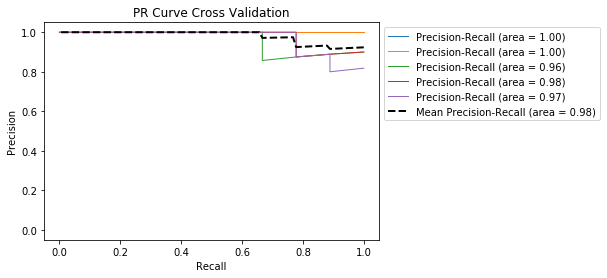

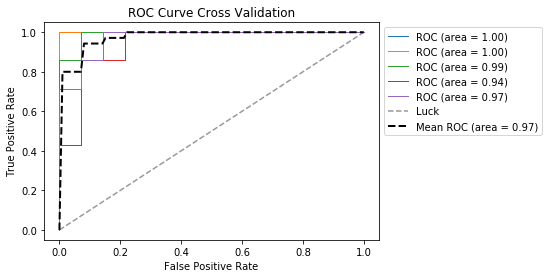

In [13]:
#plotting CV for Log reg
fig_lr = cross_val_pr(0,x_train_top,y_train_top,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/sb_analysis/figures/lr_sbTOP50_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_top,y_train_top,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/sb_analysis/figures/lr_sbTOP50_cv_roc.pdf',bbox_inches='tight')


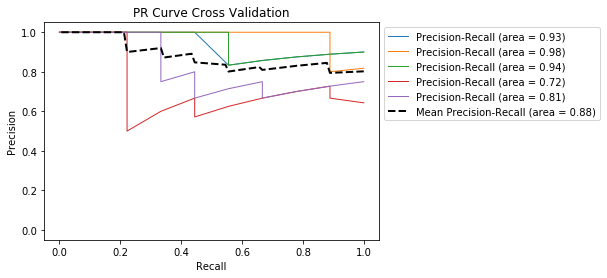

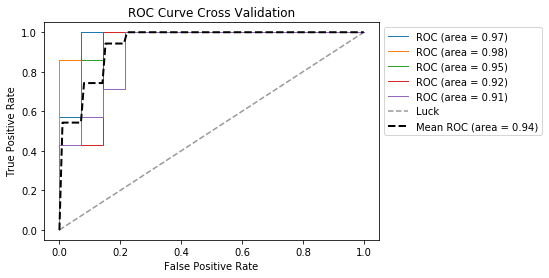

In [14]:
#plotting CV for RF
fig_rf = cross_val_pr(1,x_train_top,y_train_top,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/sb_analysis/figures/rf_sbTOP50_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_top,y_train_top,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/sb_analysis/figures/rf_sbTOP50_cv_roc.pdf',bbox_inches='tight')


In [15]:
#training Log Reg on training data
top_lr = LogisticRegression(random_state=0,max_iter=200)
top_lr.fit(x_train_top, y_train_top)

LogisticRegression(max_iter=200, random_state=0)

In [16]:
#training RF on training data
top_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
top_rf.fit(x_train_top, y_train_top)
top_rf.oob_score_

0.8857142857142857

### 1b. Testing the models on G3P Samples

In [17]:
# get all the samples that are G3R
test_samples = [idx for idx in meta[meta.ATTRIBUTE_groups=='G3R'].index if idx in serum_tablepd.index]
test_table = meta.loc[test_samples][['ATTRIBUTE_groups','ATTRIBUTE_adv_fibrosis']]
test_table.rename(columns={'ATTRIBUTE_groups':'groups','ATTRIBUTE_adv_fibrosis':'adv_fibrosis'},inplace=True)
#have to drop Missing: Not collected values
test_table = test_table[test_table.adv_fibrosis != 'Missing: Not collected']
print(test_table.adv_fibrosis.value_counts())

0    21
1     7
Name: adv_fibrosis, dtype: int64


In [18]:
# Preparing the test data for SB
x_test_top = sb_top50_table.loc[test_table.index]
y_test_top = []
for idx in test_table.index:
    if test_table.loc[idx,'adv_fibrosis'] == '1':
        y_test_top.append(1)
    elif test_table.loc[idx,'adv_fibrosis'] == '0':
        y_test_top.append(0)
y_test_top = np.array(y_test_top)
print(x_test_top.shape)
print(len(y_test_top))

(28, 50)
28


In [19]:
#plotting Precision Recall curve 
#(code used from calour.plot_roc http://biocore.github.io/calour/generated/calour.training.plot_roc.html)
def plot_result_pr(result,title,cv=True):
    from sklearn import metrics
    from matplotlib import pyplot as plt
    from scipy import interp
    import itertools
    
    cmap = plt.cm.Dark2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    #ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    classes = np.unique(result['Y_TRUE'].values)
    classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_recall = np.linspace(1, 0, 100)
    for cls in classes:
        precisions = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                precision, recall, thresholds = metrics.precision_recall_curve(y_true.astype(int), result[cls])
                rev_recall = recall[::-1]
                rev_precision = precision[::-1]
                mean_precision = np.interp(mean_recall, rev_recall, rev_precision)
                precisions.append(mean_precision)
                precisions[-1][0] = 0.0
                pr_auc = metrics.auc(mean_recall, mean_precision)
                aucs.append(pr_auc)

            mean_precision = np.mean(precisions, axis=0)
            #mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_recall, mean_precision, color=col[cls],
                    label='{0} ({1:.2f} $\\pm$ {2:.2f})'.format(cls, mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_precision = np.std(precisions, axis=0)
            precisions_upper = np.minimum(mean_precision + std_precision, 1)
            precisions_lower = np.maximum(mean_precision - std_precision, 0)
            ax.fill_between(mean_recall, precisions_lower, precisions_upper, color=col[cls], alpha=.5)
        else:
            y_true = result['Y_TRUE'].values == cls
            precision, recall, thresholds = metrics.precision_recall_curve(y_true.astype(int), result[cls])
            pr_auc = auc(recall, precision)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(recall, 0, 0), np.insert(precision, 0, 0), label='{0} ({1:.2f})'.format(cls, pr_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc="lower right")

    #return ax, mean_auc if cv else pr_auc
    return plt

In [20]:
#plotting ROC curve 
#(code used from calour.plot_roc http://biocore.github.io/calour/generated/calour.training.plot_roc.html)
def plot_result_roc(result,title,cv=True):    
    from sklearn import metrics
    from matplotlib import pyplot as plt
    from scipy import interp
    import itertools
    
    cmap = plt.cm.Dark2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    classes = np.unique(result['Y_TRUE'].values)
    classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_fpr = np.linspace(0, 1, 100)
    for cls in classes:
        tprs = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                fpr, tpr, thresholds = metrics.roc_curve(y_true.astype(int), df[cls])
                mean_tpr = np.interp(mean_fpr, fpr, tpr)
                tprs.append(mean_tpr)
                tprs[-1][0] = 0.0
                roc_auc = metrics.auc(mean_fpr, mean_tpr)
                aucs.append(roc_auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color=col[cls],
                    label='{0} ({1:.2f} $\\pm$ {2:.2f})'.format(cls, mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=col[cls], alpha=.5)
        else:
            y_true = result['Y_TRUE'].values == cls
            fpr, tpr, thresholds = roc_curve(y_true.astype(int), result[cls])
            roc_auc = auc(fpr, tpr)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), label='{0} ({1:.2f})'.format(cls, roc_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

    #return ax, mean_auc if cv else roc_auc
    return plt

In [21]:
#testing the logistic regression base model
result_top_lr = pd.DataFrame(top_lr.predict_proba(x_test_top))
result_top_lr.columns = top_lr.classes_
result_top_lr['Y_TRUE'] = y_test_top
result_top_lr['CV'] = 0

Average precision-recall score: 0.34


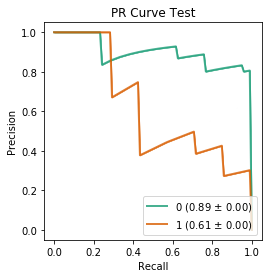

In [22]:
#plotting results as Precision Recall curve
fig_lr = plot_result_pr(result_top_lr,'PR Curve Test')
fig_lr.savefig('ml_analysis/sb_analysis/figures/lr_sbTOP50_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_top, top_lr.predict(x_test_top))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.57


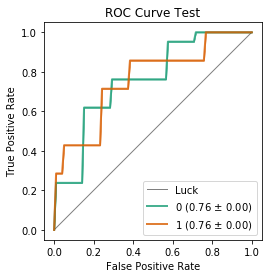

In [23]:
#plotting results as ROC
fig_lr = plot_result_roc(result_top_lr,'ROC Curve Test')
fig_lr.savefig('ml_analysis/sb_analysis/figures/lr_sbTOP50_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_top, top_lr.predict(x_test_top))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [24]:
#testing the logistic regression base model
result_top_rf = pd.DataFrame(top_rf.predict_proba(x_test_top))
result_top_rf.columns = top_rf.classes_
result_top_rf['Y_TRUE'] = y_test_top
result_top_rf['CV'] = 0

Average precision-recall score: 0.26


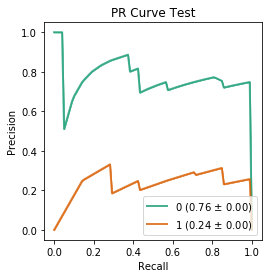

In [25]:
#plotting results as Precision Recall curve
fig_rf = plot_result_pr(result_top_rf,'PR Curve Test')
fig_rf.savefig('ml_analysis/sb_analysis/figures/rf_sbTOP50_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_top, top_rf.predict(x_test_top))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.36


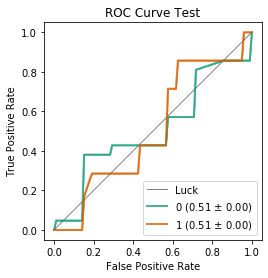

In [26]:
#plotting results as ROC
fig_rf = plot_result_roc(result_top_rf,'ROC Curve Test')
fig_rf.savefig('ml_analysis/sb_analysis/figures/rf_sbTOP50_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_top, top_rf.predict(x_test_top))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

## 2. Songbird Top25+Bot25

### 2a. CV/Train the models on the G1P+G3P individuals

In [27]:
#preparing training data for SB top 50
x_train_tb = sb_tb25_table.loc[train_table.index]
#label encoder
y_train_tb = []
for idx in train_table.index:
    if train_table.loc[idx,'adv_fibrosis'] == '1':
        y_train_tb.append(1)
    #even values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_tb.append(0)
y_train_tb = np.array(y_train_tb)
print(x_train_tb.shape)
print(len(y_train_tb))

(70, 50)
70


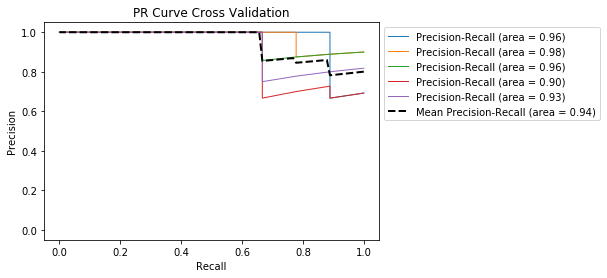

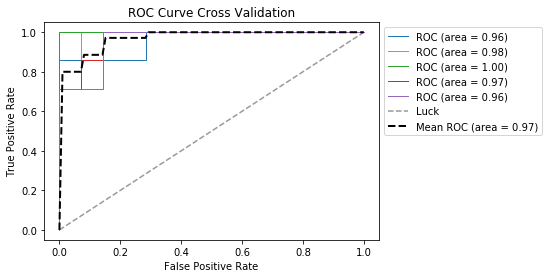

In [28]:
#plotting Precision-recall for Log Reg
fig_lr = cross_val_pr(0,x_train_tb,y_train_tb,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/sb_analysis/figures/lr_sbTB25_cv_pr.pdf',bbox_inches='tight')

#plotting ROC for Log Reg
fig_lr = cross_val_roc(0,x_train_tb,y_train_tb,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/sb_analysis/figures/lr_sbTB25_cv_roc.pdf',bbox_inches='tight')


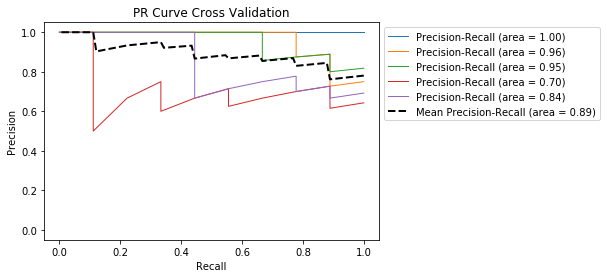

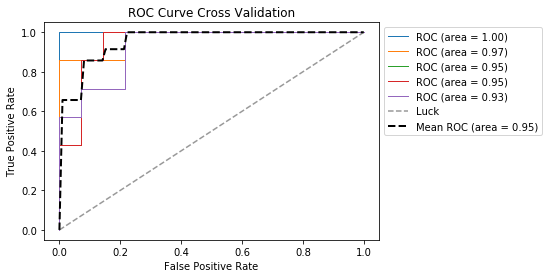

In [29]:
#plotting Precision-recall for RF
fig_rf = cross_val_pr(1,x_train_tb,y_train_tb,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/sb_analysis/figures/rf_sbTB25_cv_pr.pdf',bbox_inches='tight')

#plotting ROC for Log Reg
fig_rf = cross_val_roc(1,x_train_tb,y_train_tb,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/sb_analysis/figures/rf_sbTB25_cv_roc.pdf',bbox_inches='tight')


In [30]:
#training Log Reg on training data
tb_lr = LogisticRegression(random_state=0,max_iter=200)
tb_lr.fit(x_train_tb, y_train_tb)

LogisticRegression(max_iter=200, random_state=0)

In [31]:
#training RF on training data
tb_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
tb_rf.fit(x_train_tb, y_train_tb)
tb_rf.oob_score_

0.9

### 2b. Testing models on G3R Samples

In [32]:
# Preparing the test data for top 25 bot 25
x_test_tb = sb_tb25_table.loc[test_table.index]
y_test_tb = []
for idx in test_table.index:
    if test_table.loc[idx,'adv_fibrosis'] == '1':
        y_test_tb.append(1)
    elif test_table.loc[idx,'adv_fibrosis'] == '0':
        y_test_tb.append(0)
y_test_tb = np.array(y_test_tb)
print(len(x_test_tb))
print(len(y_test_tb))

28
28


In [33]:
#testing the logistic regression model
result_tb_lr = pd.DataFrame(tb_lr.predict_proba(x_test_tb))
result_tb_lr.columns = tb_lr.classes_
result_tb_lr['Y_TRUE'] = y_test_tb
result_tb_lr['CV'] = 0

Average precision-recall score: 0.31


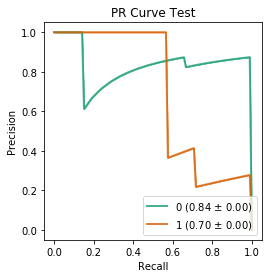

In [34]:
#plotting results as Precision Recall curve
fig_lr = plot_result_pr(result_tb_lr,'PR Curve Test')
fig_lr.savefig('ml_analysis/sb_analysis/figures/lr_sbTB25_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_tb, tb_lr.predict(x_test_tb))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.64


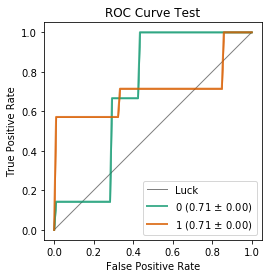

In [35]:
#plotting results as ROC
fig_lr = plot_result_roc(result_tb_lr,'ROC Curve Test')
fig_lr.savefig('ml_analysis/sb_analysis/figures/lr_sbTB25_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_tb, tb_lr.predict(x_test_tb))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [36]:
#testing the logistic regression base model
result_tb_rf = pd.DataFrame(tb_rf.predict_proba(x_test_tb))
result_tb_rf.columns = tb_rf.classes_
result_tb_rf['Y_TRUE'] = y_test_tb
result_tb_rf['CV'] = 0

Average precision-recall score: 0.22


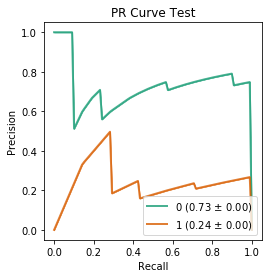

In [37]:
#plotting results as Precision Recall curve
fig_rf = plot_result_pr(result_tb_rf,'PR Curve Test')
fig_rf.savefig('ml_analysis/sb_analysis/figures/rf_sbTB25_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_tb, tb_rf.predict(x_test_tb))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.25


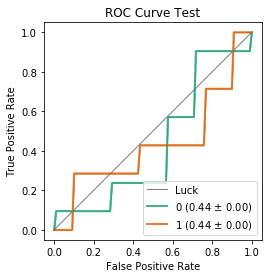

In [38]:
#plotting results as ROC
fig_rf = plot_result_roc(result_tb_rf,'ROC Curve Test')
fig_rf.savefig('ml_analysis/sb_analysis/figures/rf_sbTB25_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_tb, tb_rf.predict(x_test_tb))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

## Exporting Feature Importance
Creating table of feature ID w/ feature importance for Alex to look at molecular networking

In [39]:
feat_info = pd.read_csv('classified-feature-data.tsv',sep='\t')
feat_info.head(3)

,id,#featureID,csi_smiles,ms2_smiles,ms2_compound,ms2_adduct,table_number,smiles,annotation_type,kingdom,superclass,class,subclass,direct_parent
0,da5dc9007216de85908619b0d8d6c065,395,CCCCCCCCCCC(=NC(CCCNC(=N)N)C(=NC(CC1=CC=CC=C1)...,NaN,NaN,NaN,1,CCCCCCCCCCC(=NC(CCCNC(=N)N)C(=NC(CC1=CC=CC=C1)...,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
1,b5a7b5651a9dd589ebba875701732d11,4673,CCCCCC=CCC=CCCCCCCCC(=O)OCC(COP(=O)([O-])OCC[N...,NaN,NaN,NaN,1,CCCCCC=CCC=CCCCCCCCC(=O)OCC(COP(=O)([O-])OCC[N...,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
2,5a307cd7a787f5b3269a7d6c0175fb2e,2513,CCC(C(C(CO)N(C)CC(C(C(C(C(CO)O)O)O)O)O)O)O,NaN,NaN,NaN,1,CCC(C(C(CO)N(C)CC(C(C(C(C(CO)O)O)O)O)O)O)O,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified


In [40]:
tb_imp = pd.Series(tb_rf.feature_importances_).to_frame()
tb_imp.columns = ['feat importance']

In [41]:
#going through table to find featureID
id_col = []
hash_col = []
king_col = []
supclass_col = []
class_col = []
subclass_col = []
dp_col = []
sb_col = []
for idx in tb_imp.index:
    hash_id = sb_tb25_table.columns[idx]
    sb_diff = sb_diff_AF[sb_diff_AF.featureid==hash_id]['ATTRIBUTE_adv_fibrosis[T.1]'].iloc[0]
    sb_col.append(sb_diff)
    hash_col.append(hash_id)
    fbmn_id = feat_info[feat_info.id==hash_id]['#featureID'].iloc[0]
    taxa = feat_info.loc[idx][['kingdom','superclass','class','subclass','direct_parent']]
    king_col.append(taxa[0])#+','+taxa[1]+','+taxa[2]+','+taxa[3]+','+taxa[4]
    supclass_col.append(taxa[1])
    class_col.append(taxa[2])
    subclass_col.append(taxa[3])
    dp_col.append(taxa[4])
    id_col.append(fbmn_id)

In [42]:
tb_imp['hashedID'] = hash_col
tb_imp['featueID'] = id_col
tb_imp['ATTRIBUTE_adv_fibrosis[T.1]'] = sb_col
tb_imp['kingdom'] = king_col
tb_imp['superclass'] = supclass_col
tb_imp['class'] = class_col 
tb_imp['subclass'] = subclass_col
tb_imp['direct_parent'] = dp_col
tb_imp.head()

,feat importance,hashedID,featueID,ATTRIBUTE_adv_fibrosis[T.1],kingdom,superclass,class,subclass,direct_parent
0,0.058852,cad6579a4a3666ba17eb7df0f0a49deb,108,4.250413,unclassified,unclassified,unclassified,unclassified,unclassified
1,0.028443,7dd110cefad8f55e39e353c5389a1a98,83,4.242195,unclassified,unclassified,unclassified,unclassified,unclassified
2,0.024183,26264d872b76e26a3e261e0d183b8a3d,289,4.228135,unclassified,unclassified,unclassified,unclassified,unclassified
3,0.024385,bdc8f0f8e01251da0dbaba2975b4bb74,209,4.216336,Organic compounds,Lipids and lipid-like molecules,Glycerophospholipids,Glycerophosphocholines,1-acyl-sn-glycero-3-phosphocholines
4,0.016825,acb7269def0f8dc125ceb679f1e5b9eb,1568,4.215017,unclassified,unclassified,unclassified,unclassified,unclassified


In [43]:
tb_imp.to_csv('./ml_analysis/sb_analysis/sb-topbot-featimp-taxa.tsv',sep='\t',index=False)

## 3. Songbird Bottom 50 Feature Set

### 3a. CV/Train Models on G1P+G3P Samples

In [52]:
#preparing training data for SB top 50
x_train_bot = sb_bot50_table.loc[train_table.index]
#label encoder
y_train_bot = []
for idx in train_table.index:
    if train_table.loc[idx,'adv_fibrosis'] == '1':
        y_train_bot.append(1)
    #even values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_bot.append(0)
y_train_bot = np.array(y_train_bot)
print(x_train_bot.shape)
print(len(y_train_bot))

(70, 50)
70


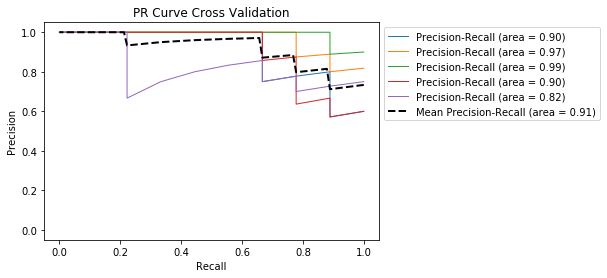

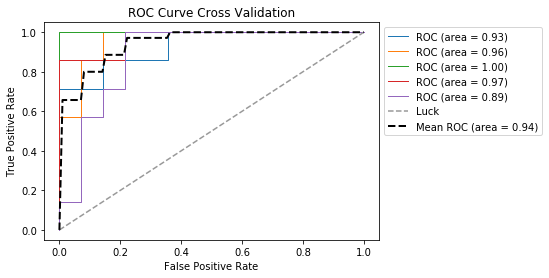

In [40]:
#plotting Precision-recall for Log Reg
fig_lr = cross_val_pr(0,x_train_bot,y_train_bot,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/sb_analysis/figures/lr_sbBOT50_cv_pr.pdf',bbox_inches='tight')

#plotting Precision-recall for Log Reg
fig_lr = cross_val_roc(0,x_train_bot,y_train_bot,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/sb_analysis/figures/lr_sbBOT50_cv_roc.pdf',bbox_inches='tight')


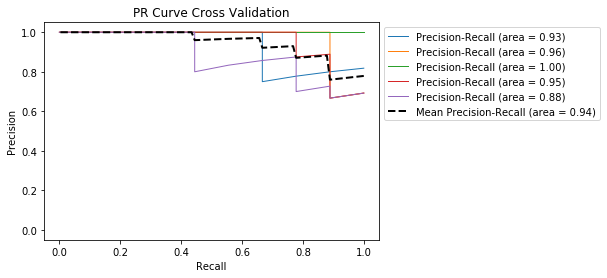

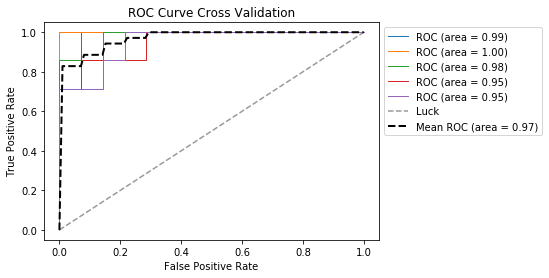

In [41]:
#plotting CV for RF
fig_rf = cross_val_pr(1,x_train_bot,y_train_bot,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/sb_analysis/figures/rf_sbBOT50_cv_pr.pdf',bbox_inches='tight')

#plotting ROC for RF
fig_rf = cross_val_roc(1,x_train_bot,y_train_bot,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/sb_analysis/figures/rf_sbBOT50_cv_roc.pdf',bbox_inches='tight')


In [53]:
#training Log Reg on training data
bot_lr = LogisticRegression(random_state=0,max_iter=200)
bot_lr.fit(x_train_bot, y_train_bot)

LogisticRegression(max_iter=200, random_state=0)

In [54]:
#training RF on training data
bot_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
bot_rf.fit(x_train_bot, y_train_bot)
bot_rf.oob_score_

0.8714285714285714

### 3b. Test Models on G3R Samples

In [55]:
# Preparing the test data for BAB and SB
x_test_bot = sb_bot50_table.loc[test_table.index]
y_test_bot = []
for idx in test_table.index:
    if test_table.loc[idx,'adv_fibrosis'] == '1':
        y_test_bot.append(1)
    elif test_table.loc[idx,'adv_fibrosis'] == '0':
        y_test_bot.append(0)
y_test_bot = np.array(y_test_bot)
print(len(x_test_bot))
print(len(y_test_bot))

28
28


In [56]:
#testing the logistic regression base model
result_bot_lr = pd.DataFrame(bot_lr.predict_proba(x_test_bot))
result_bot_lr.columns = bot_lr.classes_
result_bot_lr['Y_TRUE'] = y_test_bot
result_bot_lr['CV'] = 0

Average precision-recall score: 0.27


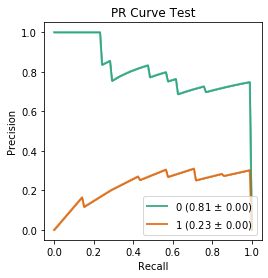

In [46]:
#plotting results as Precision Recall curve
fig_lr = plot_result_pr(result_bot_lr,'PR Curve Test')
fig_lr.savefig('ml_analysis/sb_analysis/figures/lr_sbBOT50_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_bot, bot_lr.predict(x_test_bot))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.32


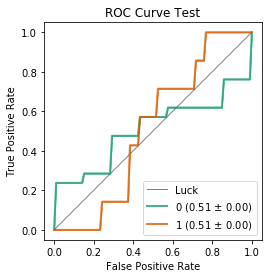

In [47]:
#plotting results as ROC
fig_lr = plot_result_roc(result_bot_lr,'ROC Curve Test')
fig_lr.savefig('ml_analysis/sb_analysis/figures/lr_sbBOT50_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_bot, bot_lr.predict(x_test_bot))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [48]:
#testing the logistic regression base model
result_bot_rf = pd.DataFrame(bot_rf.predict_proba(x_test_bot))
result_bot_rf.columns = bot_rf.classes_
result_bot_rf['Y_TRUE'] = y_test_bot
result_bot_rf['CV'] = 0

Average precision-recall score: 0.27


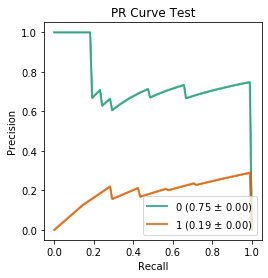

In [49]:
#plotting results as Precision Recall curve
fig_rf = plot_result_pr(result_bot_rf,'PR Curve Test')
fig_rf.savefig('ml_analysis/sb_analysis/figures/rf_sbBOT50_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_bot, bot_rf.predict(x_test_bot))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.32


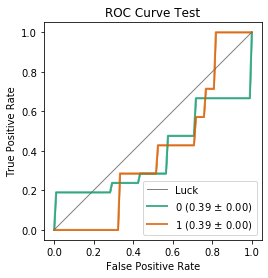

In [57]:
#plotting results as ROC
fig_rf = plot_result_roc(result_bot_rf,'ROC Curve Test')
fig_rf.savefig('ml_analysis/sb_analysis/figures/rf_sbBOT50_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_bot, bot_rf.predict(x_test_bot))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

## Export the list of Features

In [58]:
with open('./ml_analysis/sb_analysis/songbird-topbot-feat.txt', 'w') as f:
    for item in sb_tb25_id:
        f.write("%s\n" % item)

## 4. Adding BMI, Gender and Age to Feature Table
In the previous study done on the microbiome, adding BMI, Gender and Age to the feature table gave solid accuracy improvments for the model. These features are already used in the clinical setting as a way to diagnos NAFLD through uninvasive means. From this analysis the best performing model was the Songbird Top25/Bot25 Model.

In [61]:
clin_feat = meta.loc[:,['ATTRIBUTE_BiologicalSex','ATTRIBUTE_bmi','ATTRIBUTE_age']]
clin_feat.rename(columns={"ATTRIBUTE_BiologicalSex": "gender", "ATTRIBUTE_bmi": "bmi","ATTRIBUTE_age":"age"},inplace=True)
clin_feat

,gender,bmi,age
sample_name,,,
CIR16-001_BE5_01_29885.mzXML,female,38.95012056,52.0
CIR16-002_RC7_01_29715.mzXML,female,31.03390116,71.0
CIR18-001_BD4_01_29873.mzXML,female,34.86434801,63.0
CIR18-002_BC9_01_29855.mzXML,female,33.56161928,63.0
CIR19-001_RB12_01_29707.mzXML,female,42.66915271,61.0
...,...,...,...
TW-DZ-001_RA12_01_29694.mzXML,female,32.5,65.0
TW-DZ-002_RB4_01_29699.mzXML,female,30.1,65.0
TW-EE-001_RB3_01_29801.mzXML,male,24.4,21.0


### 4a. Train Models on G1P+G3P Individuals

In [62]:
x_train_comb = pd.concat([sb_tb25_table.loc[train_table.index], clin_feat.loc[train_table.index]],axis=1)
x_train_comb.gender = pd.factorize(x_train_comb.gender)[0]
x_train_comb = x_train_comb[x_train_comb.bmi != 'Missing: Not collected']
print(x_train_comb.shape)

(79, 53)


**Had to remove one sample that was Missing BMI value**

In [63]:
y_train_comb = []
for idx in x_train_comb.index:
    if meta.loc[idx, 'ATTRIBUTE_adv_fibrosis'] == '1':
        y_train_comb.append(1)
    else:    
        y_train_comb.append(0)
y_train_comb = np.array(y_train_comb)
print(len(y_train_comb))
print(y_train_comb.sum())

79
23


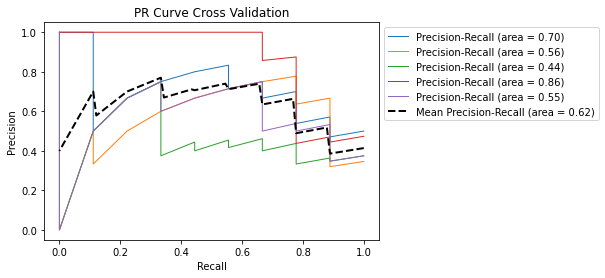

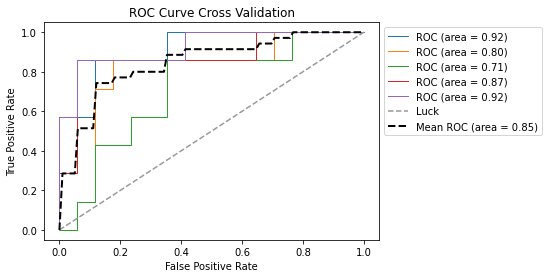

In [64]:
#Cross Validating the Log Reg
fig_lr = cross_val_pr(0,x_train_comb,y_train_comb,'PR Curve Cross Validation')
fig_lr.savefig('fecal_ml_analysis/figures/lr_sbTB25+meta_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_comb,y_train_comb,'ROC Curve Cross Validation')
fig_lr.savefig('fecal_ml_analysis/figures/lr_sbTB25+meta_cv_roc.pdf',bbox_inches='tight')


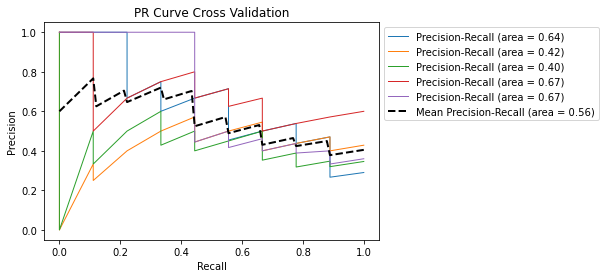

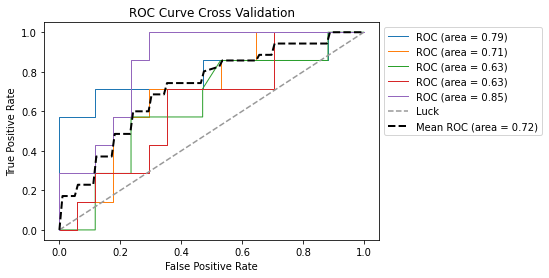

In [65]:
#Cross Validating the RF
fig_rf = cross_val_pr(1,x_train_comb,y_train_comb,'PR Curve Cross Validation')
fig_rf.savefig('fecal_ml_analysis/figures/rf_sbTB25+meta_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_comb,y_train_comb,'ROC Curve Cross Validation')
fig_rf.savefig('fecal_ml_analysis/figures/rf_sbTB25+meta_cv_roc.pdf',bbox_inches='tight')


In [66]:
#training Log Reg on training data
comb_lr = LogisticRegression(random_state=0,max_iter=350)
comb_lr.fit(x_train_comb, y_train_comb)

LogisticRegression(max_iter=350, random_state=0)

In [67]:
#training RF on training data
comb_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
comb_rf.fit(x_train_comb, y_train_comb)
comb_rf.oob_score_

0.810126582278481

### 4b. Testing Models on G3R Samples

In [68]:
x_test_comb = pd.concat([sb_tb25_table.loc[test_table.index], clin_feat.loc[test_table.index]],axis=1)
x_test_comb.gender = pd.factorize(x_test_comb.gender)[0]
x_test_comb.shape

(32, 53)

In [69]:
# Preparing the test data
y_test_comb = []
for idx in x_test_comb.index:
    if meta.loc[idx,'ATTRIBUTE_adv_fibrosis'] == '1':
        y_test_comb.append(1)
    elif meta.loc[idx,'ATTRIBUTE_adv_fibrosis'] == '0':
        y_test_comb.append(0)
y_test_comb = np.array(y_test_comb)
print(len(y_test_comb))

32


In [70]:
#testing log reg
result_comb_lr = pd.DataFrame(comb_lr.predict_proba(x_test_comb))
result_comb_lr.columns = comb_lr.classes_
result_comb_lr['Y_TRUE'] = y_test_comb
result_comb_lr['CV'] = 0

Average precision-recall score: 0.47


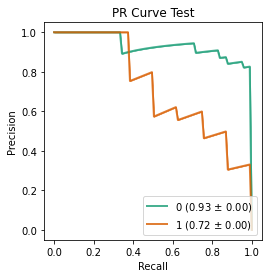

In [71]:
#showing Precision-recall results
fig_comb_lr = plot_result_pr(result_comb_lr,'PR Curve Test')
fig_comb_lr.savefig('fecal_ml_analysis/figures/lr_sbTB25+meta_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_comb, comb_lr.predict(x_test_comb))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.78


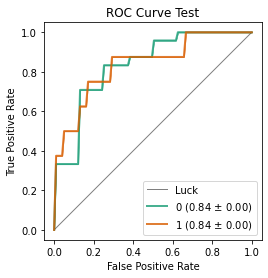

In [72]:
#showing accuracy/ROC results
fig_comb_lr = plot_result_roc(result_comb_lr,'ROC Curve Test')
fig_comb_lr.savefig('fecal_ml_analysis/figures/lr_sbTB25+meta_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_comb, comb_lr.predict(x_test_comb))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [73]:
#testing RF
result_comb_rf = pd.DataFrame(comb_rf.predict_proba(x_test_comb))
result_comb_rf.columns = comb_rf.classes_
result_comb_rf['Y_TRUE'] = y_test_comb
result_comb_rf['CV'] = 0

Average precision-recall score: 0.41


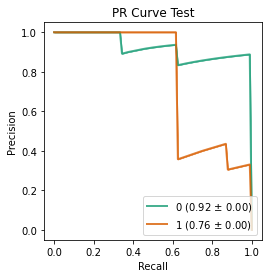

In [74]:
#showing Precision-recall results
fig_comb_rf = plot_result_pr(result_comb_rf,'PR Curve Test')
fig_comb_rf.savefig('fecal_ml_analysis/figures/rf_sbTB25+meta_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_comb, comb_rf.predict(x_test_comb))

print('Average precision-recall score: {0:0.2f}'.format(
    
      average_precision))

Accuracy score: 0.75


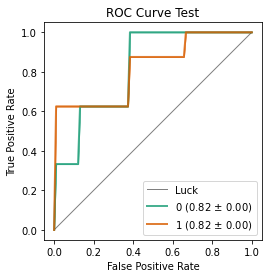

In [75]:
#showing accuracy/ROC results
fig_comb_rf = plot_result_roc(result_comb_rf,'ROC Curve Test')
fig_comb_rf.savefig('fecal_ml_analysis/figures/rf_sbTB25+meta_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_comb, comb_rf.predict(x_test_comb))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

### Investigating Top25+Bot25 SB Features

In [6]:
sb_tb_feat = pd.read_csv('./fecal_ml_analysis/sonbird_topbot.txt',sep='\t',header=None)
sb_tb_feat.columns = ['id']
sb_tb_feat.head()

,id
0,fb758530086adf438d5ebe8f83847f2d
1,0ba75f593218ef056eefaeab285ae839
2,cdf8d23687cfc324485e2bd3e0094ff2
3,d2ef3361261cc1d835ad59394bfe161c
4,4deeef4aa3231abf469afec860b7b1ea


In [4]:
feat_info = pd.read_csv('./classified-feature-table-data.tsv',sep='\t')
feat_info.head()

,id,#featureID,csi_smiles,ms2_smiles,ms2_library_match,parent_mass,retention_time,table_number,smiles,structure_source,kingdom,superclass,class,subclass,direct_parent
0,056d022e7adbe4ef6653efa05d5b8112,667,CCCCCCC=CCCCCCCCC(=O)OCC,missing,missing,283.2632,6.1332,1,CCCCCCC=CCCCCCCCC(=O)OCC,CSIFingerID,Organic compounds,Lipids and lipid-like molecules,Fatty Acyls,Fatty acid esters,Fatty acid esters
1,735cc5e83b0891f3f3f7187f8ee70423,946,CC(C)CC(=NCCCCCN)O,missing,missing,187.1805,0.9041,1,CC(C)CC(=NCCCCCN)O,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
2,3602250da02502454e038abb20d0bb7e,1179,missing,missing,missing,284.2949,4.5907,1,missing,missing,unclassified,unclassified,unclassified,unclassified,unclassified
3,d66ab13eb87fd0f6688ef1f5332cf25f,330,C1=CC=C(C=C1)C=CO,missing,missing,121.0640,1.6710,1,C1=CC=C(C=C1)C=CO,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
4,3a2a812b26a0df79b008f0ca30844218,122,C1=CC=C(C=C1)CC(C(=O)O)N,missing,Phenylalanine,166.0873,9.8312,1,C1=CC=C(C=C1)CC(C(=O)O)N,CSIFingerID,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",Phenylalanine and derivatives


In [10]:
filt_feat_info = feat_info[feat_info.id.isin(sb_tb_feat.id)]
filt_feat_info

,id,#featureID,csi_smiles,ms2_smiles,ms2_library_match,parent_mass,retention_time,table_number,smiles,structure_source,kingdom,superclass,class,subclass,direct_parent
12,f174e3629110b9080182a65e91cd4735,643,CCCCCC=CCC=CCCCCCCCCC#CO,CC(/CCC1C(=C)CCC2C(C)(C)CCCC12C)=C/CO,"NCGC00385919-01_C20H34O_2-Penten-1-ol, 5-[(1S,...",291.2679,5.1520,1,CC(/CCC1C(=C)CCC2C(C)(C)CCCC12C)=C/CO,MS2,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Diterpenoids,Diterpenoids
60,9d3664902e2848338dd710fded7d8434,42,CCCCC1=NC(=C(CO)N1CC2=CC=C(C=C2)C3=C(C=CC=C3)C...,CCCCC1=NC(Cl)=C(CO)N1Cc1ccc(-c2ccccc2C2=NNN=N2...,MassbankEU:SM818901 Losartan|[2-butyl-5-chloro...,423.1691,3.2091,1,CCCCC1=NC(Cl)=C(CO)N1Cc1ccc(-c2ccccc2C2=NNN=N2...,MS2,Organic compounds,Benzenoids,Benzene and substituted derivatives,Biphenyls and derivatives,Biphenyls and derivatives
114,87fe8c126302167c9c2dd616d938702c,44,CC(CCC1=NC(=C(CO)N1CC2=CC=C(C=C2)C3=C(C=CC=C3)...,missing,missing,439.1643,3.0034,1,CC(CCC1=NC(=C(CO)N1CC2=CC=C(C=C2)C3=C(C=CC=C3)...,CSIFingerID,Organic compounds,Benzenoids,Benzene and substituted derivatives,Biphenyls and derivatives,Biphenyls and derivatives
124,87b2ee3ab5930cf0663d663ff1b3c524,14,missing,missing,missing,431.3531,8.8194,1,missing,missing,unclassified,unclassified,unclassified,unclassified,unclassified
138,724dece7c572c5e0d5aabf61684111fb,95,CC(CCC(=O)O)C1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,C[C@@H]([C@H]1CC[C@]2([H])[C@]1(C)CC[C@@]3([H]...,"(R)-4-((8S,9S,10R,13R,14S,17R)-10,13-dimethyl-...",373.2738,4.8976,1,C[C@@H]([C@H]1CC[C@]2([H])[C@]1(C)CC[C@@]3([H]...,MS2,Organic compounds,Lipids and lipid-like molecules,Steroids and steroid derivatives,"Bile acids, alcohols and derivatives","Bile acids, alcohols and derivatives"
189,35841b633732fc98d6bc6a0056cdb239,491,[CH]CCCCCC(CCCCCCCCCCC(=O)O)O,missing,missing,299.2579,5.5963,1,[CH]CCCCCC(CCCCCCCCCCC(=O)O)O,CSIFingerID,Organic compounds,Lipids and lipid-like molecules,Fatty Acyls,Fatty acids and conjugates,Long-chain fatty acids
195,11aa27badd53e050c47d272982cb6175,578,CC1=CN(C)C(=O)C(=N1)C,missing,missing,139.0856,1.3086,1,CC1=CN(C)C(=O)C(=N1)C,CSIFingerID,Organic compounds,Organoheterocyclic compounds,Diazines,Pyrazines,Pyrazines
203,4508ce20c9b99a6e1c24fd3afdbc1e2f,1028,CC=CC=CCN=C(C)O,missing,missing,140.1063,2.6116,1,CC=CC=CCN=C(C)O,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
212,d2ef3361261cc1d835ad59394bfe161c,1018,C(COCCOCCOCCOCCOCCOCCOCCOCCOCCO)O,missing,Spectral Match to Decaethylene glycol from NIST14,459.2799,2.4980,1,C(COCCOCCOCCOCCOCCOCCOCCOCCOCCO)O,CSIFingerID,Organic compounds,Organic oxygen compounds,Organooxygen compounds,Ethers,Polyethylene glycols
213,fb758530086adf438d5ebe8f83847f2d,1022,CC(C)CC(C(=NC(C)C)O)N=C(C(CO)N=C(C1CCC(=N1)O)O)O,missing,missing,393.2100,2.4014,1,CC(C)CC(C(=NC(C)C)O)N=C(C(CO)N=C(C1CCC(=N1)O)O)O,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
